In [2]:

from two_body_nn import * 
import numpy as np 

data = np.load('aspirin-2000.npz')
z_atom = data['z']
positions = data['R']
atomic_list = np.unique(z_atom).tolist()
atom_types = np.zeros_like(positions[:,:,0], dtype=int)
for iframe in range(len(positions)):
    atom_types[iframe] = z_atom

energies = data['E']
forces = data['F']

# Convert numpy arrays to PyTorch tensors
positions_tensor = torch.tensor(positions, dtype=torch.float32)
energies_tensor = torch.tensor(energies, dtype=torch.float32)
forces_tensor = torch.tensor(forces, dtype=torch.float32)
atom_types_tensor = torch.tensor(atom_types, dtype=torch.long)

#shift energy 
energies_tensor = energies_tensor - torch.mean(energies_tensor)

# Split the data into training and validation sets
train_size = 1500
val_size = 500

train_positions = positions_tensor[:train_size]
train_energies = energies_tensor[:train_size]
train_forces = forces_tensor[:train_size]
train_atom_types = atom_types_tensor[:train_size]

val_positions = positions_tensor[train_size:]
val_energies = energies_tensor[train_size:]
val_forces = forces_tensor[train_size:]
val_atom_types = atom_types_tensor[train_size:]

# Initialize the model
model = TwoBodyNN(atomic_list, cutoff=4.0)

# Load the best model state
model.load_state_dict(torch.load('best_two_body_nn.pth'))
#model.eval()  # Set the model to evaluation mode


/var/folders/2c/lfzfq0012pb5j6tby9ds3dq80000gn/T/ipykernel_18806/965807674.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_two_bo

<All keys matched successfully>

In [3]:
predicted_energy = [] 
predicted_forces = [] 
for i in range(val_size):
   e, f = model.compute_forces(val_atom_types[i], val_positions[i])
   predicted_energy.append(e.detach().numpy())
   predicted_forces.append(f.detach().numpy())





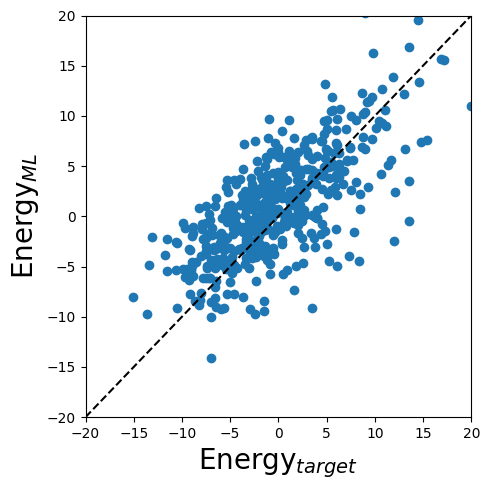

In [4]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(5,5))
predicted_energy = np.asarray(predicted_energy)
plt.scatter(val_energies.detach().numpy(), predicted_energy,zorder=-1)

plt.xlim([-20,20])
plt.ylim([-20,20])
plt.plot([-20,20],[-20,20],zorder=1,c = 'k', linestyle='--')

plt.xlabel(r'Energy$_{target}$', fontsize=20)
plt.ylabel(r'Energy$_{ML}$', fontsize=20)
plt.tight_layout()
plt.savefig('fit-E.jpg', dpi = 500)

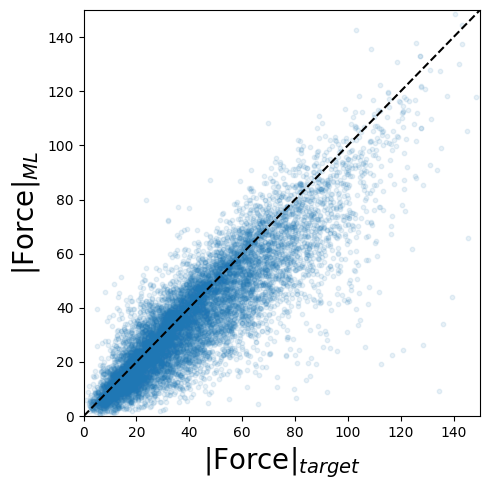

In [5]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(5,5))
predicted_f_abs =np.sum(  np.asarray(predicted_forces)**2 ,-1)**0.5 
val_f_abs = np.sum( val_forces.detach().numpy()**2 ,-1)**0.5 
plt.scatter(val_f_abs, predicted_f_abs,s=10,alpha=0.1,zorder=-1)

plt.xlim([0,150])
plt.ylim([0,150])
plt.plot([0,150],[0,150],zorder=1,c = 'k', linestyle='--')
plt.xlabel(r'|Force|$_{target}$', fontsize=20)
plt.ylabel(r'|Force|$_{ML}$', fontsize=20)
plt.tight_layout()
plt.savefig('fit-F.jpg', dpi = 500)